<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Давайте-посмоотрим-на-данные" data-toc-modified-id="Давайте-посмоотрим-на-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Давайте посмоотрим на данные</a></span><ul class="toc-item"><li><span><a href="#Загружаем-данные" data-toc-modified-id="Загружаем-данные-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загружаем данные</a></span></li><li><span><a href="#Модифицируем-данные" data-toc-modified-id="Модифицируем-данные-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Модифицируем данные</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import random

In [2]:
DATA_PATH = './data/Accel_data/data_raw.txt'

## Давайте посмоотрим на данные
### Загружаем данные

In [3]:
dictionary = {'user':[], 'activity':[], 'time':[], 'x_acc':[],'y_acc':[],'z_acc':[] }

def parse_line( line):
    user = activity = time = x_acc = y_acc = z_acc = None
    try:
        string = line.strip(';\n').split(',')
        user = int( string[ 0 ])
        activity = string[ 1 ]
        time = int( string[ 2 ])
        x_acc = float( string[ 3 ])
        y_acc = float( string[ 4 ])
        z_acc = float( string[ 5 ])
    except:
        print( 'dropped', line)
    else:
        if time and time > 1e-9:
            dictionary['user'].append(user)
            dictionary['activity'].append( activity)
            dictionary['time'].append( time)
            dictionary['x_acc'].append( x_acc)
            dictionary['y_acc'].append( y_acc)
            dictionary['z_acc'].append( z_acc)

with open (DATA_PATH, "r") as file:
    for line in file.readlines():
        for sline in line.split(';'):
            if sline.strip():
                parse_line( sline)
row_data = pd.DataFrame(data = dictionary)
row_data = row_data.sort_values(by = ['user', 'time'])

row_data.head(10)

dropped 11,Walking,1867172313000,4.4,4.4,



,user,activity,time,x_acc,y_acc,z_acc
929120,1,Walking,4991922345000,0.69,10.80,-2.03
929121,1,Walking,4991972333000,6.85,7.44,-0.50
929122,1,Walking,4992022351000,0.93,5.63,-0.50
929123,1,Walking,4992072339000,-2.11,5.01,-0.69
929124,1,Walking,4992122358000,-4.59,4.29,-1.95
929125,1,Walking,4992172376000,12.41,11.18,7.82
929126,1,Walking,4992222333000,17.27,11.60,5.94
929127,1,Walking,4992272321000,1.42,8.43,-5.28
929128,1,Walking,4992322339000,-2.68,15.89,-0.38
929129,1,Walking,4992372327000,-1.38,9.92,-1.99


In [4]:
print( row_data.size//len(row_data.columns))
users = set(row_data.user)
activities = set(row_data.activity)
print(users)
print(activities)

1085363
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}
{'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking', 'Downstairs'}


# [28]


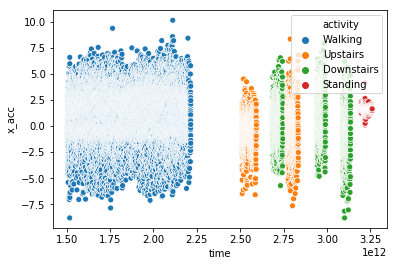

In [5]:
user = random.sample(users, 1)
sns.scatterplot(x="time", y="x_acc", hue="activity",data=row_data[row_data.user == user])
print('#', user)
plt.show()

### Модифицируем данные
Номер пользователя является избыточной информацией, вместо нее введем номер трека, для каждого типа движения

In [6]:
row_cols = ['user', 'activity', 'time', 'x_acc','y_acc','z_acc']
cols = ['track', 'activity', 'time', 'x_acc', 'y_acc', 'z_acc']
data_list = []
for i in range(len(dictionary['user'])):
    data_list.append([dictionary[key][i] for key in row_cols])

data_list.sort(key = lambda x: (x[0], x[2]))

user = -1
activity = None
track = -1 # Therefore first will be 0
startpoint = 0
last = None
data_dict = {key:[] for key in cols}
traks_by_type = {key:[] for key in activities}
for row in data_list:
    delta = row[2] - last if last is not None else None
    if user != row[0] or activity != row[1] or (delta and delta < 0.25):
        track += 1
        activity = row[1]
        user = row[0]
        startpoint = row[2]
        last = None
        traks_by_type[activity].append(track)
    data_dict['track'].append(track)
    data_dict['activity'].append(activity)
    data_dict['time'].append((row[2] - startpoint)/1e9)
    data_dict['x_acc'].append(row[3])
    data_dict['y_acc'].append(row[4])
    data_dict['z_acc'].append(row[5])
    last = data_dict['time'][-1]
data = pd.DataFrame(data=data_dict)
data.head()

,track,activity,time,x_acc,y_acc,z_acc
0,0,Walking,0.000000,0.69,10.80,-2.03
1,0,Walking,0.049988,6.85,7.44,-0.50
2,0,Walking,0.100006,0.93,5.63,-0.50
3,0,Walking,0.149994,-2.11,5.01,-0.69
4,0,Walking,0.200013,-4.59,4.29,-1.95


In [7]:
num_tacks = track
for key, value in traks_by_type.items():
    print('%s: %i'%(key, len(value)))

Jogging: 55
Sitting: 23
Standing: 24
Upstairs: 120
Walking: 59
Downstairs: 117


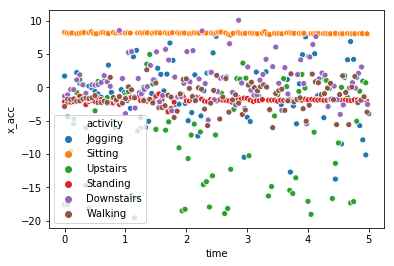

In [8]:
tr_ids = [random.choice(x) for x in  traks_by_type.values()]
sns.scatterplot(x="time", y="x_acc", hue="activity",
                data=data[data.track.apply(lambda v: v in tr_ids) & (data.time < 5)])
plt.show()

В описании датасета сказано, что данныйе включают ускорение, земного притяжения равное 10, поэтому перейдем к призноковуму описанию: ускорение к "центру земли| перпенддикулярное ускорение | положение телефона (угол между z - осью и направлением к центру земли)